In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

train_df = pd.read_csv('DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
test_df = pd.read_csv('DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)

train_df = train_df.dropna()
test_df = test_df.dropna()

train_df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [31]:
test_df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...
2018-10-27,24.750000,54.250000,3.475000,1013.875000
2018-10-28,20.875000,57.250000,7.875000,1015.875000
2018-10-29,22.125000,63.500000,1.850000,1016.875000


In [32]:
features = ['meantemp', 'humidity', 'meanpressure']

data_train = train_df[features].values
data_test = test_df[features].values

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)

In [34]:
sequence_length = 30

In [35]:
X_train, y_train = [], []
for i in range(len(data_train_scaled) - sequence_length):
    X_train.append(data_train_scaled[i:i+sequence_length, :])
    y_train.append(data_train_scaled[i+sequence_length, :])

X_train, y_train = np.array(X_train), np.array(y_train)

In [36]:
# Define the model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), activation="relu"))
model.add(Dense(7, activation="relu"))  
model.add(Dense(3)) 
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 7)                 455       
                                                                 
 dense_5 (Dense)             (None, 3)                 24        
                                                                 
Total params: 17887 (69.87 KB)
Trainable params: 17887 (69.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
history = model.fit(X_train, y_train, epochs=50, batch_size=330, validation_split=0.1, verbose=1)

Epoch 1/50
4/4 [==============================] - 0s 111ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 2/50
4/4 [==============================] - 0s 86ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/50
4/4 [==============================] - 0s 81ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 4/50
4/4 [==============================] - 0s 82ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 5/50
4/4 [==============================] - 0s 80ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 6/50
4/4 [==============================] - 0s 79ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 7/50
4/4 [==============================] - 0s 84ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 8/50
4/4 [==============================] - 0s 76ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 9/50
4/4 [==============================] - 0s 75ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 10/50
4/4 [==============================] - 0s 73ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 11/50
4/4 [===========

In [44]:
X_test, y_test = [], []
for i in range(len(data_test_scaled) - sequence_length):
    X_test.append(data_test_scaled[i:i+sequence_length, :])
    y_test.append(data_test_scaled[i+sequence_length, :])
X_test, y_test = np.array(X_test), np.array(y_test)

test_predictions_scaled = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

19/19 [==============================] - 0s 6ms/step


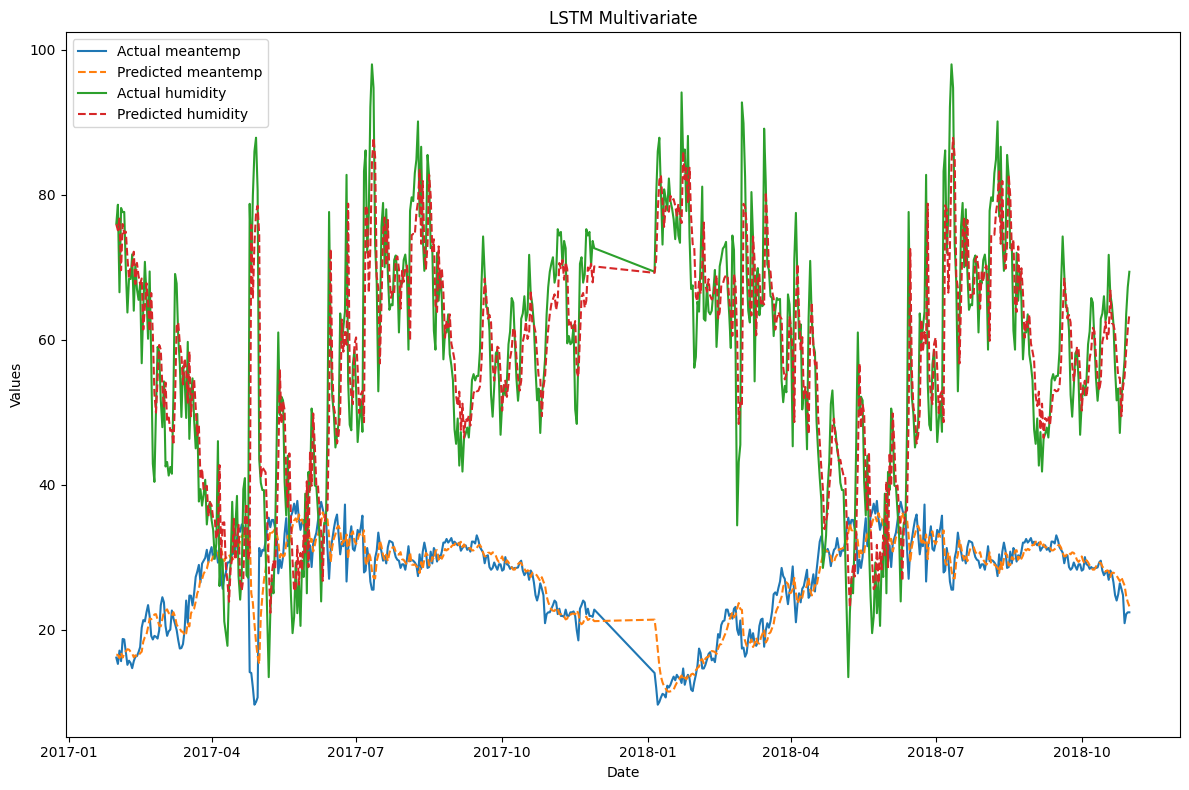

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot the results
for i in range(2):
    plt.plot(test_df.index[sequence_length:], data_test[sequence_length:, i], label='Actual ' + features[i])
    plt.plot(test_df.index[sequence_length:], test_predictions[:, i], label='Predicted ' + features[i], linestyle='dashed')

plt.ylabel('Values')
plt.xlabel('Date')
plt.legend()
plt.title('LSTM Multivariate')
plt.tight_layout()
plt.show()

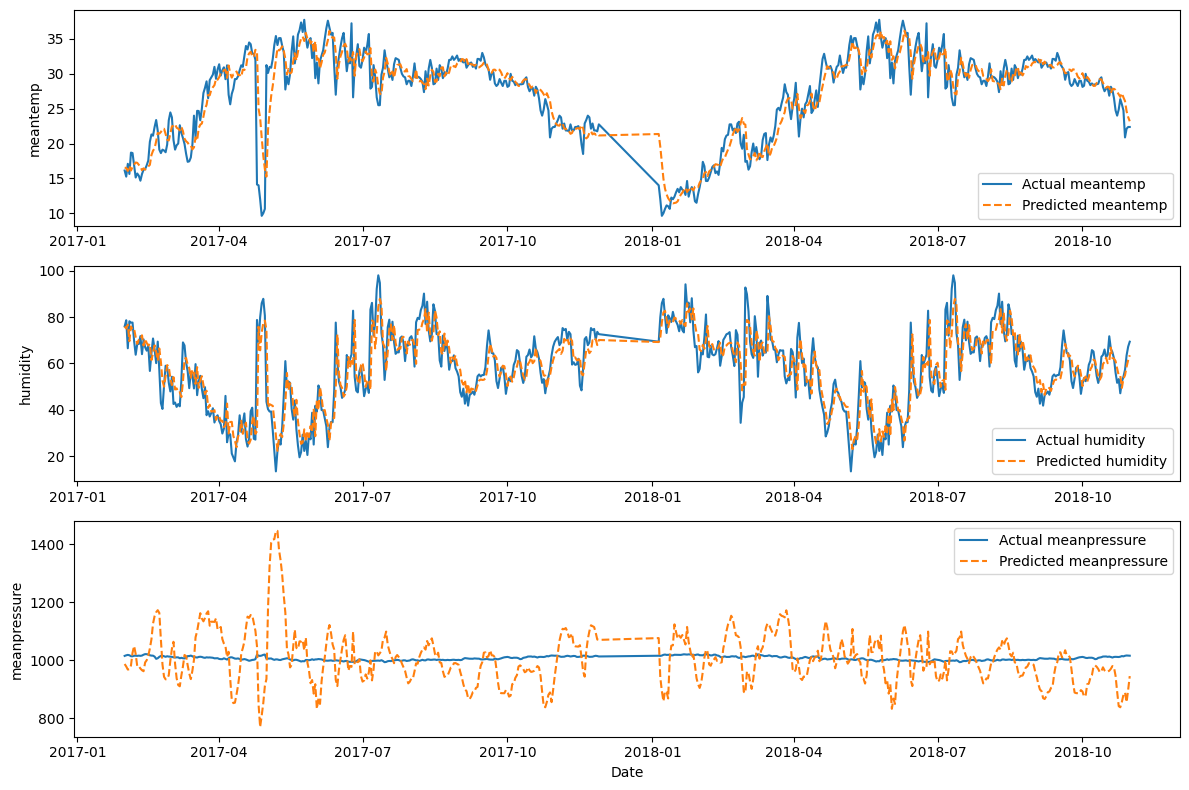

In [46]:
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(test_df.index[sequence_length:], data_test[sequence_length:, i], label='Actual ' + features[i])
    plt.plot(test_df.index[sequence_length:], test_predictions[:, i], label='Predicted ' + features[i], linestyle='dashed')
    plt.ylabel(features[i])
    plt.legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [47]:
rmse_features = []
for i in range(3):
    rmse_feature = np.sqrt(mean_squared_error(data_test[sequence_length:, i], test_predictions[:, i]))
    rmse_features.append(rmse_feature)
    print(f"RMSE for {features[i]}: {rmse_feature}")

RMSE for meantemp: 2.4019049834719217
RMSE for humidity: 8.154274298703653
RMSE for meanpressure: 90.20125406076454


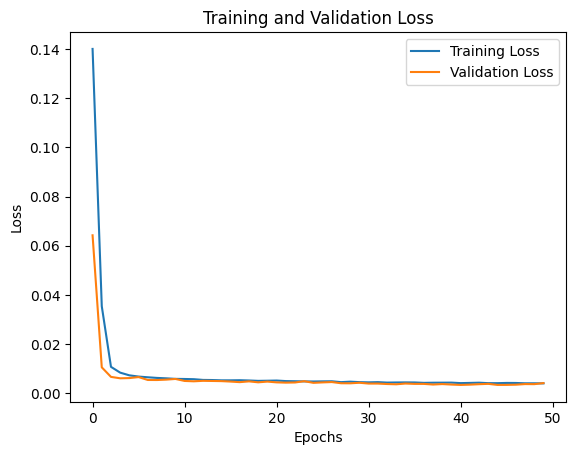

In [42]:
# Plot epochs vs loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()